In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
from scipy.spatial import distance_matrix
%matplotlib inline

import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

# Functions

In [11]:
def aligment_rotation(reference, not_reference):
    
    ref = mda.Universe(reference)
    mobile = mda.Universe(not_reference)
    
    ref0 = ref.select_atoms('name CA').positions - ref.atoms.center_of_mass()
    mobile0 = mobile.select_atoms('name CA').positions - mobile.atoms.center_of_mass()
    #mobile_all = mobile0
    mobile_all = mobile.select_atoms('all').positions - mobile.atoms.center_of_mass()
    
    Ra, rmsd = align.rotation_matrix(mobile0, ref0)
    mobile_rotated=np.dot(Ra, mobile_all.T)
    
    return (Ra, mobile_rotated)

def aligment_rotation_coord(reference, not_reference):
    
    Ra, mobile_rotated = aligment_rotation(reference, not_reference)
    
    mobile_rot_x=mobile_rotated[0]
    mobile_rot_y=mobile_rotated[1]
    mobile_rot_z=mobile_rotated[2]
    
    return (mobile_rot_x, mobile_rot_y, mobile_rot_z)

def quaternion_rotation(q, x, y, z):
    
    Q = R.from_quat(q).as_matrix()
    
    coord = np.array([x,y,z])
    rot_coord = np.dot(Q, coord)
    
    x_rot = rot_coord[0]
    y_rot = rot_coord[1]
    z_rot = rot_coord[2]
    
    return(x_rot, y_rot, z_rot)

def i_sel (x,xi,sigma,n):
    
    return (i for i in range(len(x)) if abs(x[i]-xi)<=n*sigma)

def I_calculated_A (x_atom, y_atom, sigma, n, res):
    
    x = np.linspace(min(x_atom)-1,max(x_atom)+1, res)
    y = np.linspace(min(y_atom)-1,max(y_atom)+1, res)
    
    Ixy = 0
    Ax=[]
    Ay=[]
    
    for atom in range(len(x_atom)):
        
        X = np.zeros(len(x))
        Y = np.zeros(len(x))
        
        i_x_selected=list(i_sel (x,x_atom[atom],sigma,n))
        i_y_selected=list(i_sel (y,y_atom[atom],sigma,n))
        
        X[i_x_selected]=np.exp(-0.5*(((x[i_x_selected]-x_atom[atom])/sigma)**2))
        Y[i_y_selected]=np.exp(-0.5*(((y[i_y_selected]-y_atom[atom])/sigma)**2))
                
        Ixy += np.matmul(X.reshape(len(x),1), Y.reshape(1,len(y)))
        
        Ax_atom=np.matmul((((x-x_atom[atom])/sigma**2)*X).reshape(len(x),1),Y.reshape(1,len(Y)))
        Ay_atom=np.matmul(X.reshape(len(x),1),(((y-y_atom[atom])/sigma**2)*Y).reshape(1,len(Y)))
        Ax.append(Ax_atom)
        Ay.append(Ay_atom)
        
    Ax=np.array(Ax)
    Ay=np.array(Ay)
    a=(1/(2*np.pi*sigma**2*len(x_atom)))
    
    return(a*Ixy, Ax, Ay)

def g2ce(Ic, Ir):
    
    s=-np.trace(np.dot(Ic, Ir.T))
    Ic_expval=np.sum(Ic)
    Ir_expval=np.sum(Ir)
    
    return(s/(Ic_expval*Ir_expval)) 

def distance(x_atom, y_atom):
    aa=np.array([[x_atom[i], y_atom[i]] for i in range(len(x_atom))])
    Dij=distance_matrix(aa,aa)
    return(Dij)

def sum_harmonic(x_atom, y_atom, d0):
    N=len(x_atom)
    D=distance(x_atom, y_atom)
    D_sum=np.sum(np.array([(D[i,i+1]-d0)**2 for i in range(N-1)]))+(D[N-1,0]-d0)**2
    return(D_sum)

def collective_variable(Ic, Ir, x_atom, y_atom, d0, w):
    return(g2ce(Ic, Ir)+w*sum_harmonic(x_atom, y_atom, d0))
    
def grad_distance(x_atom, y_atom, d0):
    
    N=len(x_atom)
    
    D=distance(x_atom, y_atom)
    
    grad_D_x=2*np.array([(D[i,i+1]-d0)*(x_atom[i]-x_atom[i+1])/D[i,i+1]-
                          (D[i,i-1]-d0)*(x_atom[i-1]-x_atom[i])/D[i,i-1] for i in range(N-1)])
    
    grad_D_y=2*np.array([(D[i,i+1]-d0)*(y_atom[i]-y_atom[i+1])/D[i,i+1]-
                          (D[i,i-1]-d0)*(y_atom[i-1]-y_atom[i])/D[i,i-1] for i in range(N-1)])
    
    grad_D_x=np.append(grad_D_x,0)
    grad_D_y=np.append(grad_D_y,0)
    grad_D_x[0]=0
    grad_D_y[0]=0
    
    grad_D=np.array([grad_D_x, grad_D_y])
    return(grad_D)
    
def grad_g2ce(Ic, Ir, Ax, Ay, N_atoms):
    
    s=-np.trace(np.dot(Ic, Ir.T))
    Ic_expval=np.sum(Ic)
    Ir_expval=np.sum(Ir)
    
    g2 = s/(Ic_expval*Ir_expval)
    
    Ic_dx=[]
    Ic_dy=[]
    s_dx=[]
    s_dy=[]
    a=(1/(2*np.pi*sigma**2*N_atoms))
    
    for i in range(N_atoms):
        Ic_dxi=a*np.sum(Ax[i])
        Ic_dyi=a*np.sum(Ay[i])
        s_dxi=-a*np.trace(np.matmul(Ax[i],Ir.T))
        s_dyi=-a*np.trace(np.matmul(Ay[i],Ir.T))
        
        Ic_dx.append(Ic_dxi)
        Ic_dy.append(Ic_dyi)
        s_dx.append(s_dxi)
        s_dy.append(s_dyi)
        
    Ic_dx=np.array(Ic_dx)
    Ic_dy=np.array(Ic_dy)
    s_dx=np.array(s_dx)
    s_dy=np.array(s_dy)

    grad_x=g2*((s_dx/s)-(Ic_dx/Ic_expval))
    grad_y=g2*((s_dy/s)-(Ic_dy/Ic_expval))
    
    grad=np.array([grad_x,grad_y])

    return(grad)

def grad_cv(Ic, Ir, Ax, Ay, N_atoms, x_atom, y_atom, d0, w):
    return(grad_g2ce(Ic, Ir, Ax, Ay, N_atoms)+w*grad_distance(x_atom, y_atom, d0))

def gradient_descent_g2(Ic, Ir, x_c, y_c, Axc, Ayc, sigma, n, res, k, N):
    
    N_atoms=len(x_c)
    x_gd=x_c
    y_gd=y_c
    grad_x, grad_y = grad_g2ce(Ic, Ir, Axc, Ayc, N_atoms)
    
    for i in tqdm(range(N)):
        x_gd = x_gd - k*grad_x
        y_gd = y_gd - k*grad_y
        Ic_gd, Axc_gd, Ayc_gd = I_calculated_A (x_gd, y_gd, sigma, n, res)
        grad_x, grad_y = grad_g2ce(Ic_gd, Ir, Axc_gd, Ayc_gd, N_atoms)
    
    g2 = g2ce(Ic_gd, Ir)
    grad_gd = grad_x, grad_y
    
    return (g2, grad_gd, Ic_gd)

def gradient_descent_cv(Ic, Ir, x_c, y_c, d0, w, Axc, Ayc, sigma, n, res, k, N):
    
    N_atoms=len(x_c)
    x_gd=x_c
    y_gd=y_c
    grad_x, grad_y = grad_cv(Ic, Ir, Axc, Ayc, N_atoms, x_gd, y_gd, d0, w)
    
    for i in tqdm(range(N)):
        x_gd = x_gd - k*grad_x
        y_gd = y_gd - k*grad_y
        Ic_gd, Axc_gd, Ayc_gd = I_calculated_A (x_gd, y_gd, sigma, n, res)
        grad_x, grad_y = grad_cv(Ic_gd, Ir, Axc_gd, Ayc_gd, N_atoms, x_gd, y_gd, d0, w)
        
    
    cv = collective_variable(Ic_gd, Ir, x_gd, y_gd, d0, w)
    grad_gd = grad_x, grad_y
    
    return (cv, grad_gd, Ic_gd)

def gradient_descent_g2_anh(Ic, Ir, x_c, y_c, Axc, Ayc, sigma0, sigmaf, n, res, k, N):
    
    N_atoms=len(x_c)
    x_gd=x_c
    y_gd=y_c
    grad_x, grad_y = grad_g2ce(Ic, Ir, Axc, Ayc, N_atoms)
    
    for i in tqdm(range(N)):
        x_gd = x_gd - k*grad_x
        y_gd = y_gd - k*grad_y
        sigma =-((sigma0-sigmaf)/(N-1))*i + sigma0
        Ic_gd, Axc_gd, Ayc_gd = I_calculated_A (x_gd, y_gd, sigma, n, res)
        grad_x, grad_y = grad_g2ce(Ic_gd, Ir, Axc_gd, Ayc_gd, N_atoms)
    
    g2 = g2ce(Ic_gd, Ir)
    grad_gd = grad_x, grad_y
    
    return (g2, grad_gd, Ic_gd)

def nested_gradiend_descent_g2_anh(Ic, Ir, x_c, y_c, Axc, Ayc, sigma0, sigmaf, n, res, k, N, N_int):
    
    N_atoms=len(x_c)
    x_gd=x_c
    y_gd=y_c
    grad_x, grad_y = grad_g2ce(Ic, Ir, Axc, Ayc, N_atoms)
    
    for i in tqdm(range(N)):
        sigma =-((sigma0-sigmaf)/(N-1))*i + sigma0
        
        for j in range(N_int):
            x_gd = x_gd - k*grad_x
            y_gd = y_gd - k*grad_y

            Ic_gd, Axc_gd, Ayc_gd = I_calculated_A (x_gd, y_gd, sigma, n, res)
            grad_x, grad_y = grad_g2ce(Ic_gd, Ir, Axc_gd, Ayc_gd, N_atoms)
    
    g2 = g2ce(Ic_gd, Ir)
    grad_gd = grad_x, grad_y
    
    return (g2, grad_gd, Ic_gd)


def nested_anh_gradiend_descent_cv(Ic, Ir, x_c, y_c, d0, w, Axc, Ayc, sigma0, sigmaf, n, res, k, N, N_int):
    
    N_atoms=len(x_c)
    x_gd=x_c
    y_gd=y_c
    grad_x, grad_y = grad_cv(Ic, Ir, Axc, Ayc, N_atoms, x_gd, y_gd, d0, w)
    
    for i in tqdm(range(N)):
        sigma =-((sigma0-sigmaf)/(N-1))*i + sigma0
        
        for j in range(N_int):
            x_gd = x_gd - k*grad_x
            y_gd = y_gd - k*grad_y

            Ic_gd, Axc_gd, Ayc_gd = I_calculated_A (x_gd, y_gd, sigma, n, res)
            grad_x, grad_y = grad_cv(Ic_gd, Ir, Axc_gd, Ayc_gd, N_atoms, x_gd, y_gd, d0, w)
            
    
    cv = collective_variable(Ic_gd, Ir, x_gd, y_gd, d0, w)
    grad_gd = grad_x, grad_y
    
    return (cv, grad_gd, Ic_gd)
    

# Aligment, Rotation and Projection

C:\Users\Arley\anaconda3\lib\site-packages\MDAnalysis\topology\PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "


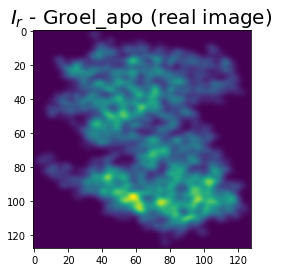

In [3]:
reference='groel_frame_13120.pdb'
not_reference='groel_apo.pdb'

q=[0,0,1/np.sqrt(2),1/np.sqrt(2)] #Quaternion parameters

n=3      #Sigma times
sigma=1  #Standar deviation of the Gaussians
res=128  #Grid's resolution

x_r, y_r, z_r = aligment_rotation_coord(reference, not_reference)

x_r, y_r, z_r = quaternion_rotation(q, x_r, y_r, z_r)

Ir, Axr, Ayr = I_calculated_A (x_r, y_r, sigma, n, res)

plt.imshow(Ir)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_r$ - Groel_apo (real image) ', fontsize=20)
plt.show()

# Atomic Coordinates for the Calculated Image

In [4]:
#Coordintes for calculated image 
N_atoms=len(x_r)
g=1

x_noise=np.random.normal(0, g, x_r.shape)
y_noise=np.random.normal(0, g, y_r.shape)

x_c=x_r+x_noise
y_c=y_r+y_noise

#x_c=np.max(x_r)*(2*np.random.random(N_atoms)-1)/2
#y_c=np.max(y_r)*(2*np.random.random(N_atoms)-1)/2

# Calculated image with anheeling, CV and Gradient

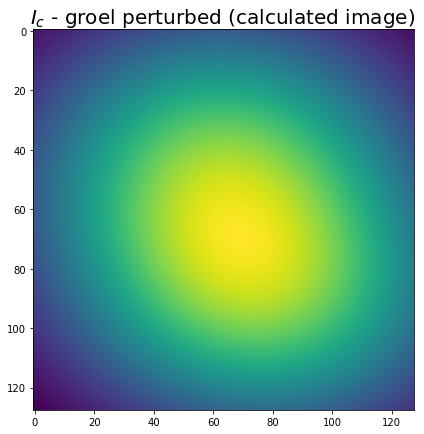

In [5]:
sigma0=20
Ic, Axc, Ayc = I_calculated_A (x_c, y_c, sigma0, n, res)

plt.imshow(Ic)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_c$ - groel perturbed (calculated image) ', fontsize=20)
plt.show()

In [12]:
d0=3
w=1e-8
g2 = g2ce(Ic, Ir)
V=sum_harmonic(x_c, y_c, d0)
CV=collective_variable(Ic, Ir, x_c, y_c, d0, w)

grad_g2 = grad_g2ce(Ic, Ir, Axc, Ayc, N_atoms)
grad_V = grad_distance(x_c, y_c, d0)
grad_CV= grad_cv(Ic, Ir, Axc, Ayc, N_atoms, x_c, y_c, d0, w)

print('g2 = {}\n'.format(g2))
print('w*V = {}\n'.format(w*V))
print('cv = {}\n'.format(CV))
print('\n')
print('grad_g2_x = {}\n'.format(grad_g2[0]))
print('w*grad_V_x = {}\n'.format(w*grad_V[0]))
print('grad_cv_x = {}\n'.format(grad_CV[0]))
print('\n')
print('grad_g2_y = {}'.format(grad_g2[1]))
print('w*grad_V_y = {}\n'.format(w*grad_V[1]))
print('grad_cv_y = {}\n'.format(grad_CV[1]))

g2 = -7.67263572083914e-05

w*V = 0.00010554102892836082

cv = 2.8814671719969414e-05



grad_g2_x = [2.04395258e-08 2.08419711e-08 1.87304467e-08 ... 2.78771033e-08
 2.71108325e-08 2.97552865e-08]

w*grad_V_x = [ 0.00000000e+00 -1.18332521e-08  6.05522821e-09 ...  3.01972153e-08
 -3.12171772e-08  0.00000000e+00]

grad_cv_x = [ 2.04395258e-08  9.00871897e-09  2.47856750e-08 ...  5.80743186e-08
 -4.10634468e-09  2.97552865e-08]



grad_g2_y = [-8.66135512e-08 -8.43121648e-08 -8.55260759e-08 ... -7.18184661e-08
 -6.81322520e-08 -7.80923714e-08]
w*grad_V_y = [ 0.00000000e+00  1.03562342e-08 -2.92184132e-08 ... -2.91480861e-08
  3.72171615e-08  0.00000000e+00]

grad_cv_y = [-8.66135512e-08 -7.39559306e-08 -1.14744489e-07 ... -1.00966552e-07
 -3.09150905e-08 -7.80923714e-08]



# Gradient Descent with decreasing $\sigma$

In [13]:
k=10e5 #Learning Rate
N=10   #Gradient Descent Steps
N_int=2
sigmaf=sigma
CV_gd, grad_gd, Ic_gd = nested_anh_gradiend_descent_cv(Ic, Ir, x_c, y_c, d0, w, Axc, Ayc, sigma0, sigmaf, n, res, k, N, N_int)

print('CV_old=',CV)
print('CV_new=',CV_gd)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:11<00:00, 13.20s/it]


CV_old= 2.8814671719969414e-05
CV_new= -0.00010497827409095621


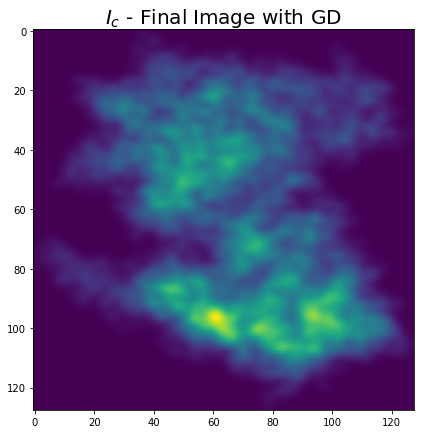

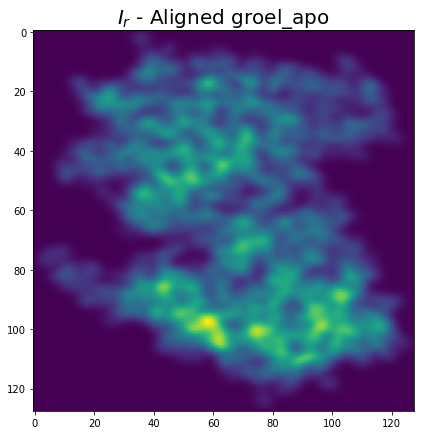

In [14]:
plt.imshow(Ic_gd)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_c$ - Final Image with GD ', fontsize=20)
plt.show()

plt.imshow(Ir)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_r$ - Aligned groel_apo ', fontsize=20)
plt.show()